In [ ]:
`!pip install "dask[complete]"
!pip install pyarrow pandas

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 18.9 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import dask.dataframe as dd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import mse
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, LayerNormalization, BatchNormalization
from sklearn.metrics import recall_score, precision_score,accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Lambda, Layer

In [ ]:
#1. Reading and Converting the Data
df_individual = dd.read_parquet('/content/drive/MyDrive/df_individual_df_40d.parquet')
df_individual_df = df_individual.compute()


In [ ]:
df_individual_df

,CUST_CUSTNO,AMOUNT,VALUEDATE
index,,,
0,a168d638771f6240e978956399d9f16621b02655b20ae8...,-9600.00,20230801
1,4fd201b58b6b81ad3366160ff82f3d53f622e0290a57db...,-100.00,20230801
2,52dcdc6af49899ae1dfae36d4eee1625fe717ac6897c2b...,-99.20,20230801
3,db34f14574441e3f42d7ea1d5299204ea481f9ac8f5ff5...,-120.00,20230801
4,49454b2d0968a2714066486a540ac8f0a57ee432cc3ca4...,-120.00,20230801
...,...,...,...
623550,b7a87502f6fc0186f4121a76a9780cb36b693e1582b8ab...,100000.00,20230909
623551,6e9f203c3dc24face6bff660ee9b32b7ea16d0efb9dfe1...,70267.53,20230909
623552,64b35de667d8ce5291f80e98f3da63931855d251eb8cb2...,52394.52,20230909


In [ ]:
# Date Conversion:
df_individual_df['VALUEDATE'] = pd.to_datetime(df_individual_df['VALUEDATE'], errors='coerce')
df_individual_df['DATE_ONLY'] = df_individual_df['VALUEDATE'].dt.date


In [ ]:
#Separate Deposits and Withdrawals
chunk_size = 100000
num_rows = df_individual_df.shape[0]

df_deposits_list = []
df_withdrawals_list = []

for start in range(0, num_rows, chunk_size):
    chunk = df_individual_df[start:start + chunk_size]
    chunk['AMOUNT'] = chunk['AMOUNT'].fillna(0)
    df_deposits_list.append(chunk[chunk['AMOUNT'] > 0])
    df_withdrawals_list.append(chunk[chunk['AMOUNT'] < 0])

df_deposits = pd.concat(df_deposits_list, ignore_index=True)
df_withdrawals = pd.concat(df_withdrawals_list, ignore_index=True)


In [ ]:

#Aggregate by Customer and Date
daily_deposits = df_deposits.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_deposits')
daily_withdrawals = df_withdrawals.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_withdrawals')


In [ ]:
#Merging and Filling Missing Values
transactions = pd.merge(daily_deposits, daily_withdrawals, on=['CUST_CUSTNO', 'DATE_ONLY'], how='outer')
transactions['total_deposits'].fillna(0, inplace=True)
transactions['total_withdrawals'].fillna(0, inplace=True)


#1. Data Preparation (Log Transformations)

In [ ]:
# Log Transform the Data
transactions['log_total_deposits'] = np.log1p(transactions['total_deposits'])
transactions['log_total_withdrawals'] = np.log1p(transactions['total_withdrawals'].abs())


# 2. Data Preprocessing with Kmeans

In [ ]:
# Applying K-means clustering
features = transactions[['log_total_deposits', 'log_total_withdrawals']].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Elbow method
wcss = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)


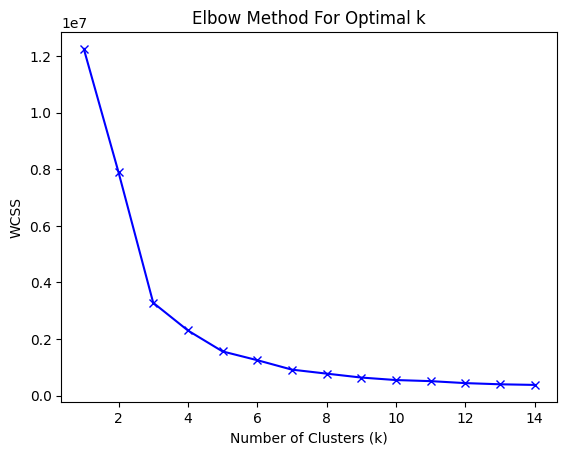

In [ ]:
plt.plot(K_range, wcss, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()


In [ ]:
print(f"Original input dimension: {features_scaled.shape}")

Original input dimension: (6128277, 2)


In [ ]:
#K-Means Clustering with Chosen K
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)
transactions['kmeans_label'] = kmeans_labels


In [ ]:
# Rule-based anomalies
rule_15_anomalies = transactions[
    (transactions['total_deposits'] >= 6000000) &
    (transactions['total_withdrawals'].abs() >= 0.95 * transactions['total_deposits'])
]
rule_15_anomalies

,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,kmeans_label
823,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,-10051700.46,16.163963,16.123252,0
830,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,-7513252.10,15.786710,15.832179,0
5825,003e0235aab29e1788ce064113f24f8703921030065318...,2023-08-07,11236003.08,-12497903.80,16.234634,16.341072,0
7971,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-03,7162326.10,-7162163.01,15.784346,15.784323,0
7973,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-07,6172231.88,-6342641.09,15.635571,15.662806,0
...,...,...,...,...,...,...,...
6119878,ffa1f3b742233373eedaf14f21c5c2833beed4b44eb6f3...,2023-08-29,27950000.05,-40949450.00,17.145928,17.527849,0
6120684,ffabda738508e4c6a75e696549413207707ac1366d57a8...,2023-08-11,6474800.00,-6316800.00,15.683428,15.658723,0
6126278,ffecb0aaab47e4d92ac4176cdee0c3d9dd4617216035c8...,2023-08-31,6242683.78,-6231263.79,15.646921,15.645090,0
6127083,fff5865d6fd5d7a5893f904b1cb18479fa79ea3b09c4b3...,2023-08-07,9435971.82,-9437298.90,16.060040,16.060180,0


In [ ]:

# Analyzing and Displaying Clusters
cluster_summary = transactions.groupby('kmeans_label').agg({
    'total_deposits': ['mean', 'std', 'min', 'max'],
    'total_withdrawals': ['mean', 'std', 'min', 'max']
})
cluster_summary

total_deposits                                   \
                       mean           std   min          max   
kmeans_label                                                   
0             160590.355891  2.621237e+06  7.13  954992660.0   
1              11195.837696  3.043670e+05  0.00  240000000.0   
2                 11.452331  3.591341e+01  0.00        270.0   

             total_withdrawals                                    
                          mean           std           min   max  
kmeans_label                                                      
0               -160787.436663  2.701862e+06 -8.917823e+08 -10.0  
1                    -3.294915  1.441045e+01 -1.370000e+02   0.0  
2                 -6842.227379  3.750896e+05 -2.833379e+08  -2.7

In [ ]:
total_samples = len(transactions)
cluster_counts = transactions['kmeans_label'].value_counts()
print("Cluster Counts and Percentage of Samples:")
for cluster_label, count in cluster_counts.items():
  percentage = (count / total_samples) * 100
  print(f"Cluster {cluster_label}: Count = {count}, Percentage = {percentage:.2f}%")


Cluster Counts and Percentage of Samples:
Cluster 2: Count = 2386093, Percentage = 38.94%
Cluster 0: Count = 2183661, Percentage = 35.63%
Cluster 1: Count = 1558523, Percentage = 25.43%


In [ ]:
#Selecting the Cluster Containing Anomalies
cluster_0_data = features_scaled[transactions['kmeans_label'] == 0]



In [ ]:
cluster_0_data.shape

(2183661, 2)

#3. VAE Deep Learning  Approach


Epoch 1/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.5973 - val_loss: 0.3260
Epoch 2/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3234 - val_loss: 0.3226
Epoch 3/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3218 - val_loss: 0.3212
Epoch 4/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3211 - val_loss: 0.3206
Epoch 5/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3209 - val_loss: 0.3206
Epoch 6/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3199 - val_loss: 0.3207
Epoch 7/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3209 - val_loss: 0.3212
Epoch 8/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3199 - val_loss: 0.3203
Epoch 9/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3198 - val_loss: 0.3201
Epoch 10/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3198 - val_loss: 0.3208
Epoch 11/100
7677/7677 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3195 - val_loss: 0.3208
Epoch 12

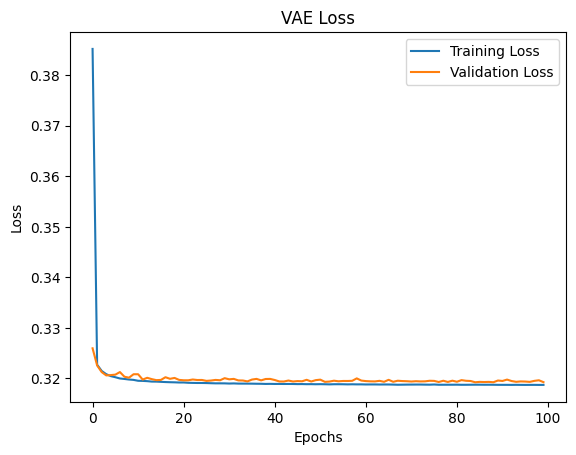

In [ ]:
# Set hyperparameters based on the input shape
latent_dim = 2  # Reduced due to the small input dimension
batch_size = 256  # Adjusted for memory efficiency
epochs = 100  # Number of epochs, can be adjusted based on convergence

# Build the Encoder model
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    h= layers.Dense(128, activation='relu')(inputs)
    h = BatchNormalization()(h)  # Add Batch Normalization
    h = layers.Dense(64, activation='relu')(h)
    h = BatchNormalization()(h)  # Add Batch Normalization
    z_mean = layers.Dense(latent_dim)(h)
    z_log_var = layers.Dense(latent_dim)(h)
    return Model(inputs, [z_mean, z_log_var])

# Build the Decoder model
def build_decoder(output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    h = layers.Dense(64, activation='relu')(latent_inputs)
    h = BatchNormalization()(h)  # Add Batch Normalization
    h = layers.Dense(128, activation='relu')(h)
    h = BatchNormalization()(h)  # Add Batch Normalization
    outputs = layers.Dense(output_dim)(h)
    return Model(latent_inputs, outputs)

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE Loss Layer
class VAELoss(layers.Layer):
    def call(self, inputs):
        x, reconstructed, z_mean, z_log_var = inputs
        reconstruction_loss = tf.reduce_mean(tf.square(x - reconstructed), axis=-1)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return reconstructed

# Build the VAE model
def build_vae(encoder, decoder):
    inputs = layers.Input(shape=(cluster_0_data.shape[1],))
    z_mean, z_log_var = encoder(inputs)
    z = Sampling()([z_mean, z_log_var])
    reconstructed = decoder(z)
    outputs = VAELoss()([inputs, reconstructed, z_mean, z_log_var])
    return Model(inputs, outputs)

# Create and compile the VAE
encoder = build_encoder(cluster_0_data.shape[1])
decoder = build_decoder(cluster_0_data.shape[1])
vae = build_vae(encoder, decoder)

vae.compile(optimizer=Adam(learning_rate=1e-4))

# Train the VAE
history = vae.fit(cluster_0_data, cluster_0_data, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VAE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#4. Anomaly Detection

**Identify Anomalies from the VAE Model**






In [ ]:

# Calculate reconstruction error
reconstructed_data = vae.predict(cluster_0_data)
reconstruction_error = np.mean(np.square(cluster_0_data - reconstructed_data), axis=1)

# Calculate the mean and standard deviation of the reconstruction error
mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)

# Define a threshold for anomaly detection
threshold = mean_error + 3 * std_error

# Identify anomalies based on the threshold
anomaly_indices_2 = np.where(reconstruction_error > threshold)[0]
anomaly_data_2 = transactions[transactions['kmeans_label'] == 0].iloc[anomaly_indices_2]


# Compare with Rule 15
rule_15_anomalies_indices = rule_15_anomalies.index
vae_anomalies_indices_2 = anomaly_data_2.index


common_anomalies_2 = set(rule_15_anomalies_indices).intersection(vae_anomalies_indices_2)
print(f"Number of common anomalies between rule 15 and VAE (2nd method): {len(common_anomalies_2)}")


# Analyzing the detected anomalies
print("Anomalies detected by VAE (2nd method):")
print(anomaly_data_2[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals']])

print("\nAnomalies detected by Rule 15:")
print(rule_15_anomalies[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals']])

cluster_0_true_labels_2 = [1 if i in rule_15_anomalies.index else 0 for i in transactions[transactions['kmeans_label'] == 0].index]
cluster_0_predicted_labels_2 = [1 if i in anomaly_data_2.index else 0 for i in transactions[transactions['kmeans_label'] == 0].index]

if len(cluster_0_true_labels_2) == len(cluster_0_predicted_labels_2):
    recall_2 = recall_score(cluster_0_true_labels_2, cluster_0_predicted_labels_2)
    precision_2 = precision_score(cluster_0_true_labels_2, cluster_0_predicted_labels_2)
    accuracy_2 = accuracy_score(cluster_0_true_labels_2, cluster_0_predicted_labels_2)
    print("Recall (2nd method):", recall_2)
    print("Precision (2nd method):", precision_2)
    print("Accuracy (2nd method):", accuracy_2)
else:
    print("Error: True labels and predicted labels have different lengths (2nd method)")


68240/68240 ━━━━━━━━━━━━━━━━━━━━ 86s 1ms/step
Number of common anomalies between rule 15 and VAE (2nd method): 5086
Anomalies detected by VAE (2nd method):
                                               CUST_CUSTNO   DATE_ONLY  \
38       0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...  2023-08-23   
283      0003c395e0d515edcb67ab689dc1c7abbe49418bae51f3...  2023-08-30   
405      0004abe134ca2b7af66656ecc3232a24a1167e71aa2bd9...  2023-08-03   
770      00091ae69bc3e7ee319270018735f8d19a10a21943a913...  2023-08-21   
771      00091ae69bc3e7ee319270018735f8d19a10a21943a913...  2023-08-22   
...                                                    ...         ...   
6127464  fff8ed8cc78dc10d90a57130047e6a56d983c50610612b...  2023-09-05   
6127577  fff97e742a783a1f7e9a398a3b326f6354a970804f4781...  2023-08-23   
6127636  fff9f06bc89d027c07ec483e7d29653bfd88fdc3863197...  2023-08-07   
6127664  fffa3a9ecb9a17a7dab4a607615ffdd4c14fb1cfed359c...  2023-09-09   
6128070  fffe7c49c726847032c91

In [ ]:
anomaly_data_2['Reconstruction_Error'] = reconstruction_error[anomaly_indices_2]
print("Anomalies detected by VAE (2nd method) with score:")
anomaly_data_2[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals', 'Reconstruction_Error']]


Anomalies detected by VAE (2nd method) with score:


,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,Reconstruction_Error
38,0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...,2023-08-23,1100000.00,-1103207.07,1.680653
283,0003c395e0d515edcb67ab689dc1c7abbe49418bae51f3...,2023-08-30,1100000.00,-2200000.00,1.934431
405,0004abe134ca2b7af66656ecc3232a24a1167e71aa2bd9...,2023-08-03,2111765.34,-2075882.63,2.081004
770,00091ae69bc3e7ee319270018735f8d19a10a21943a913...,2023-08-21,2766676.53,-3459676.53,2.414481
771,00091ae69bc3e7ee319270018735f8d19a10a21943a913...,2023-08-22,1907000.00,-1209576.40,1.887110
...,...,...,...,...,...
6127464,fff8ed8cc78dc10d90a57130047e6a56d983c50610612b...,2023-09-05,6157000.00,-3082589.04,2.650569
6127577,fff97e742a783a1f7e9a398a3b326f6354a970804f4781...,2023-08-23,6206100.00,-6206100.00,2.955696
6127636,fff9f06bc89d027c07ec483e7d29653bfd88fdc3863197...,2023-08-07,2799451.66,-2731825.76,2.374229
6127664,fffa3a9ecb9a17a7dab4a607615ffdd4c14fb1cfed359c...,2023-09-09,1550000.03,-1575000.00,1.897068


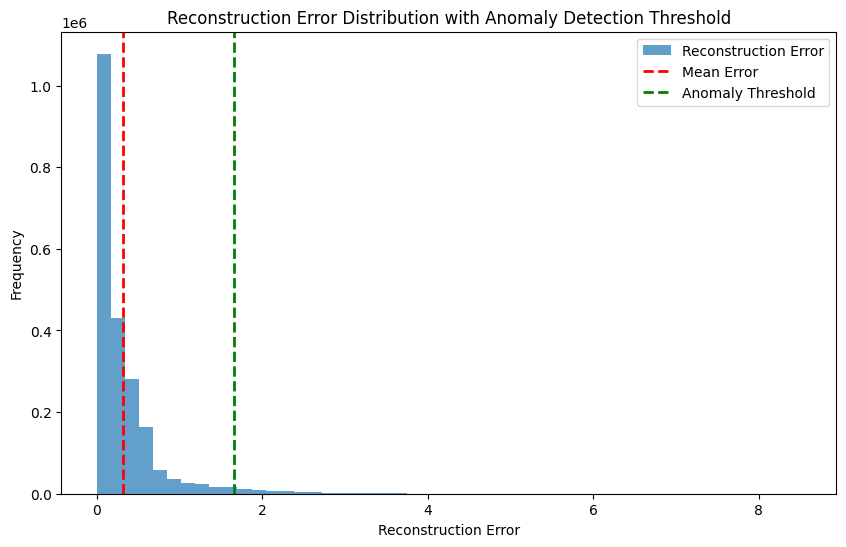

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.7, label='Reconstruction Error')
plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label='Mean Error')
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label='Anomaly Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution with Anomaly Detection Threshold')
plt.legend()
plt.show()


In [ ]:
print(f"The threshold value for anomaly detection is: {threshold}")


The threshold value for anomaly detection is: 1.6667623719178861


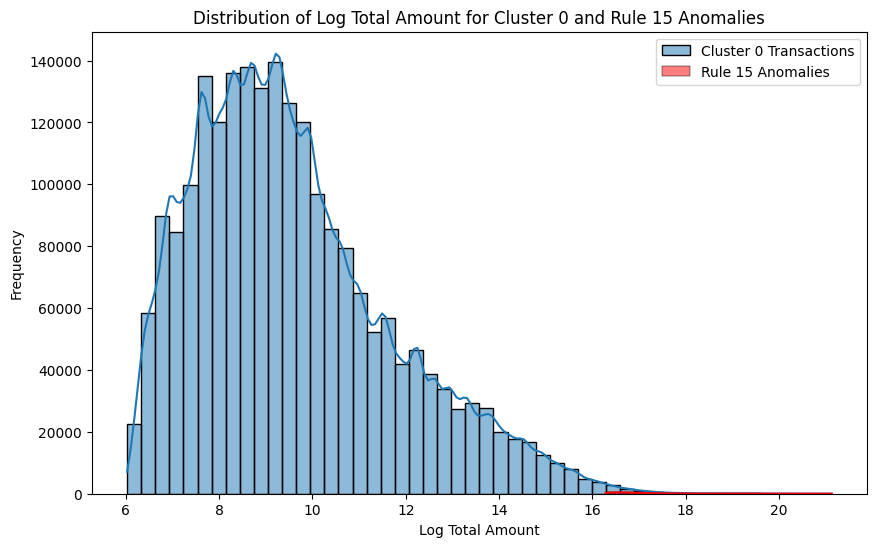

In [ ]:

# Calculate the log of total amounts for all transactions in cluster_0_data
cluster_0_data_df = transactions[transactions['kmeans_label'] == 0]
cluster_0_data_df['log_total_amount'] = np.log1p(cluster_0_data_df['total_deposits'] + cluster_0_data_df['total_withdrawals'].abs())

# Calculate the log of total amounts for rule_15 anomalies
rule_15_anomalies['log_total_amount'] = np.log1p(rule_15_anomalies['total_deposits'] + rule_15_anomalies['total_withdrawals'].abs())

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cluster_0_data_df['log_total_amount'], bins=50, kde=True, label='Cluster 0 Transactions')
sns.histplot(rule_15_anomalies['log_total_amount'], bins=50, kde=True, color='red', label='Rule 15 Anomalies')
plt.xlabel('Log Total Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Log Total Amount for Cluster 0 and Rule 15 Anomalies')
plt.legend()
plt.show()